# Toggle Hyperparameter Range

Using an old training run, we'll narrow the hyperparameter range for the LGBM and CNN models

In [1]:
import re
import ast
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GroupKFold
import shap
from datetime import datetime

In [2]:
lgbm_file = '../data/raw/lgbm_trial_04-09-2021.txt'

In [3]:
def get_performance_df(file):
    trial = 0
    trial_list = []
    with open(file, 'r') as f:
        for line in f:
            if re.search('A new study created in memory with name', line) is not None:
                trial += 1
                time_str = re.search('\[I (.*),', line).group(1)
                start_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
            else:
                param_dict = ast.literal_eval(re.search('{.*?}', line).group(0))
                performance = float(re.search('value: ([+-]?\d+\.\d+e?-?\d+?) and', line).group(1))
                time_str = re.search('\[I (.*),[0-9]+\]', line).group(1)
                end_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
                time_diff = (end_time - start_time).total_seconds()
                param_dict['time'] = time_diff
                start_time = end_time
                param_dict['performance'] = performance
                param_dict['trial'] = trial
                trial_list.append(param_dict)
    performance_df = pd.DataFrame(trial_list)
    performance_df['relative_performance'] = (performance_df.groupby('trial')
                                              ['performance']
                                              .rank(pct=True))
    return performance_df

## LGBM model

In [4]:
lgbm_performance = get_performance_df(lgbm_file)
lgbm_X = lgbm_performance[['num_leaves', 'min_child_samples', 'subsample', 'subsample_freq']]
lgbm_y = lgbm_performance['relative_performance']
predictability = cross_val_score(LGBMRegressor(random_state=7),
                                 X=lgbm_X,
                                 y=lgbm_y,
                                 cv=GroupKFold(), groups=lgbm_performance['trial'],
                                 scoring='r2')
predictability

array([0.58566352, 0.48177463, 0.78682313, 0.75804293, 0.76575801])

Given the strong dependence on subsampling, we will fix the subsample fraction to 1

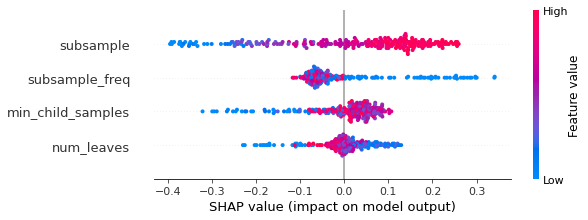

In [5]:
lgbm_model = LGBMRegressor(random_state=7)
lgbm_model.fit(lgbm_X, lgbm_y)
explainer = shap.Explainer(lgbm_model)
shap_values_lgbm = explainer(lgbm_X)
shap.plots.beeswarm(shap_values_lgbm)

In [20]:
lgbm_performance.sort_values('relative_performance')

,num_leaves,min_child_samples,subsample,subsample_freq,time,performance,trial,relative_performance
50,20,154,0.285387,57,16.0,0.405581,2,0.02
202,2,169,0.206922,26,13.0,0.295989,5,0.02
48,19,151,0.230594,17,14.0,0.404520,1,0.02
160,2,162,0.972767,71,19.0,0.374463,4,0.02
111,2,70,0.797404,74,15.0,0.377479,3,0.02
...,...,...,...,...,...,...,...,...
183,36,174,0.947997,95,26.0,0.454827,4,1.00
222,149,199,0.902136,2,25.0,0.455485,5,1.00
120,37,179,0.898057,1,20.0,0.462286,3,1.00
43,101,197,0.890587,1,22.0,0.469234,1,1.00
